In [1]:
__author__ = 'Knut Olsen <knut.olsen@noirlab.edu'
__version__ = '20230728' # yyyymmdd
__datasets__ = ['delve_dr1']
__keywords__ = ['tutorial', 'SQL', 'plot:cmd']

# Accessing the DELVE DR1 catalog
*Knut Olsen* and the DELVE Team

### Table of contents
* [Summary](#summary)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Accessing the database](#database)
* [Resources and references](#resources)

<a class="anchor" id="summary"></a>

# Summary
This is a brief intro to using the DELVE DR1 catalog through Data Lab.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [1]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

<a class="anchor" id="database"></a>
# Authentication - for accessing the database
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

In this notebook, you will need to login to access you user MyDB or VOSpace storage to save results. Un-comment the cell below and execute it:

In [2]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'demo00'

### List the columns
You can use the `qc.schema()` method to list the column names of the DELVE object table.

In [3]:
# schema and table names
wide_schema = 'delve_dr1'
wide_object = 'objects'

In [4]:
print(qc.schema(wide_schema+'.'+wide_object))


Schema: delve_dr1
 Table: objects

     Column Name   Description
     -----------   -----------
 quick_object_id   Unique identifier for each object
              ra   Right ascension derived from the median position of each d
                   etection
             dec   Declination derived from the median position of each detection
         hpx2048   NSIDE 2048 HEALPix index, in RING scheme, for each object
       mag_psf_g   PSF magnitude in g-band (see SExtractor manual for details)
       mag_psf_r   PSF magnitude in r-band (see SExtractor manual for details)
       mag_psf_i   PSF magnitude in i-band (see SExtractor manual for details)
       mag_psf_z   PSF magnitude in z-band (see SExtractor manual for details)
    magerr_psf_g   PSF magnitude error in g-band (see SExtractor manual for d
                   etails)
    magerr_psf_r   PSF magnitude error in r-band (see SExtractor manual for d
                   etails)
    magerr_psf_i   PSF magnitude error in i-band (see SExt

### A basic query
We'll make a basic query, and return the output as a Pandas dataframe.  You can write your query as SQL (Postgres).

In [5]:
sql = '''SELECT * FROM {} LIMIT 10'''.format(wide_schema+'.'+wide_object)
print(sql)
df = qc.query(sql=sql,fmt='pandas')

SELECT * FROM delve_dr1.objects LIMIT 10


In [6]:
df

,quick_object_id,ra,dec,hpx2048,mag_psf_g,mag_psf_r,mag_psf_i,mag_psf_z,magerr_psf_g,magerr_psf_r,...,flags_z,wavg_flags_g,wavg_flags_r,wavg_flags_i,wavg_flags_z,ring32,extended_class_g,extended_class_r,extended_class_i,extended_class_z
0,10829900002987,121.313058,-20.396232,41569537,15.762549,15.490513,15.418422,15.406508,0.000779,0.001146,...,0,0,0,0,0,8299,0,0,0,0
1,10829900003054,121.315687,-20.395953,41569537,21.997955,21.074883,20.828976,20.702090,0.034515,0.035999,...,0,3,3,0,0,8299,2,2,1,1
2,10829900003000,121.310460,-20.394855,41569537,20.888336,19.853489,19.417160,19.239937,0.014467,0.014078,...,0,0,0,0,0,8299,0,0,0,0
3,10829900002986,121.309294,-20.390623,41569537,20.375809,19.706959,19.469670,19.354967,0.009944,0.012641,...,0,0,0,0,0,8299,0,1,0,0
4,10829900003021,121.312090,-20.393323,41569537,19.723444,19.336601,19.203568,19.135502,0.006498,0.009849,...,0,0,0,0,0,8299,0,0,0,0
5,10829900003057,121.316143,-20.393713,41569537,20.509512,19.128529,18.448715,18.140510,0.010997,0.008528,...,0,0,0,0,0,8299,0,0,0,0
6,10829900090416,121.311787,-20.391180,41569537,99.000000,99.000000,21.890291,21.602509,99.000000,99.000000,...,0,99,99,0,0,8299,-9,-9,2,3
7,10829900003037,121.314300,-20.389447,41569537,19.423843,18.851020,18.620892,18.506130,0.005422,0.007195,...,0,0,0,0,0,8299,0,0,0,0
8,10829900002734,121.278772,-20.394359,41569536,18.815033,18.273825,99.000000,99.000000,0.003751,0.005029,...,99,2,3,99,99,8299,0,0,-9,-9
9,10829900002740,121.278255,-20.393401,41569538,20.833736,99.000000,99.000000,99.000000,0.013934,99.000000,...,99,3,99,99,99,8299,0,-9,-9,-9


### Another basic query
Here we'll look for objects associated with a specific exposure number.

In [7]:
%%time
sql = '''SELECT * FROM {} WHERE expnum_g=605691'''.format(wide_schema+'.'+wide_object)
df1 = qc.query(sql=sql,fmt='pandas')

CPU times: user 2.26 s, sys: 1.14 s, total: 3.39 s
Wall time: 12.7 s


### A cone search
Data Lab uses Q3C indices to speed up cone search queries.  Here's an example:

In [9]:
ra,dec = df1['ra'][0],df1['dec'][0]

In [10]:
sql = '''SELECT ra,dec,mag_auto_g,mag_auto_i
         FROM {2}
         WHERE Q3C_RADIAL_QUERY(ra,dec,{0},{1},1.2)'''.format(ra,dec,wide_schema+'.'+wide_object)
print(sql)

SELECT ra,dec,mag_auto_g,mag_auto_i
         FROM delve_dr1.objects
         WHERE Q3C_RADIAL_QUERY(ra,dec,132.9916106997957,-25.408956853336065,1.2)


In [11]:
%%time
dfr = qc.query(sql=sql,fmt='pandas')

CPU times: user 572 ms, sys: 182 ms, total: 755 ms
Wall time: 3.31 s


In [12]:
print(f'Result count: {len(dfr)}')

Result count: 446041


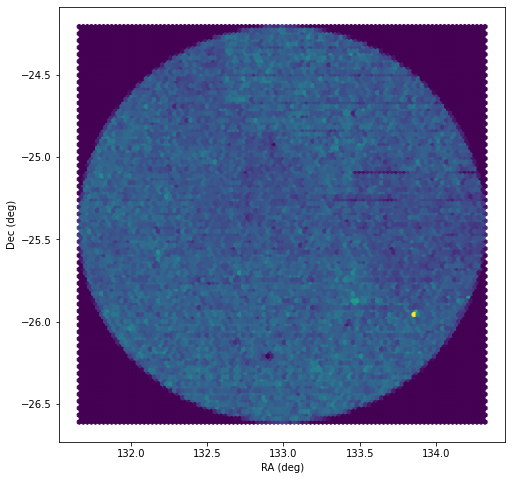

In [13]:
plt.figure(figsize=(8,8))
plt.hexbin(dfr['ra'],dfr['dec'])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

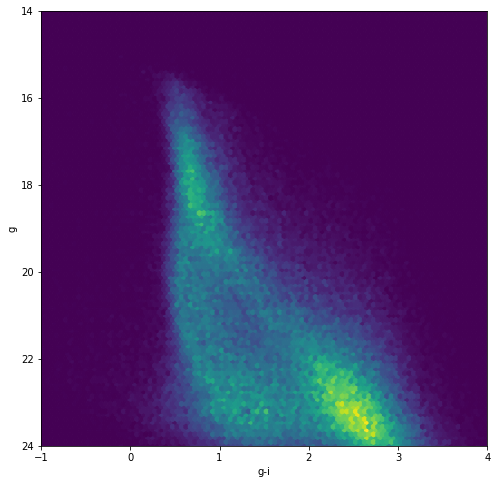

In [14]:
plt.figure(figsize=(8,8))
plt.hexbin(dfr['mag_auto_g']-dfr['mag_auto_i'],dfr['mag_auto_g'],extent=(-1,4,14,24))
plt.xlim(-1,4)
plt.ylim(24,14)
plt.xlabel('g-i')
plt.ylabel('g')
plt.show()

### Make a density map
Here we'll issue a query that aggregates objects by their Healpix ID on an NSIDE=256 RING scheme, and display the object density map.

In [15]:
%%time
sql = '''SELECT AVG(ra) AS ra0, AVG(dec) AS dec0, COUNT(ra) as nb, ring256
         FROM {}
         GROUP BY ring256'''.format(wide_schema+'.'+wide_object)
df2 = qc.query(sql=sql,fmt='pandas',timeout=600)

CPU times: user 176 ms, sys: 42.1 ms, total: 218 ms
Wall time: 1min 55s


In [16]:
map = np.zeros(hp.nside2npix(256))
map[df2['ring256']] = df2['nb']

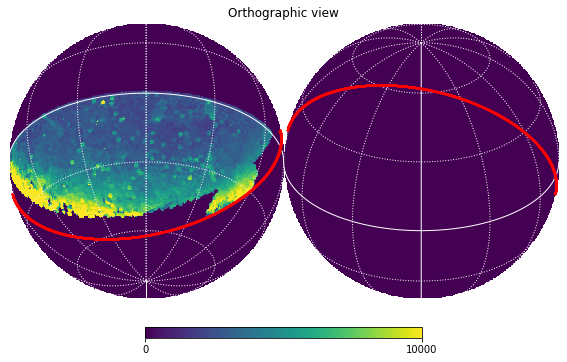

In [17]:
lon = np.arange(3600)/10
lat = np.zeros(3600)
plt.figure(figsize=(8,8))
hp.orthview(map,rot=(180,-30),min=0,max=10000,half_sky=False,fig=1,coord='C',notext=True)
hp.graticule(c='w')
foo = hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)

### Star/galaxy separation in DELVE-WIDE
The `delve_dr1.objects` catalog has several columns, named `extended_class[g,r,i,z]`, that contain a morphological class based on the spread_model parameter.  Objects with `extended_class` = 0 or 1 are likely point sources, see the [DES DR1 paper](https://www.darkenergysurvey.org/wp-content/uploads/2018/01/DR1Release.pdf) for details.

In [18]:
# select point sources with g-r<0.75, 19.5<g<22, and gerr<0.2
delvequery = '''SELECT avg(ra) as ra0,avg(dec) as dec0,hpx2048,count(hpx2048) as nb
           FROM {}
           WHERE 
           (mag_auto_g-mag_auto_r)<0.75 AND mag_auto_g>19.5 AND magerr_auto_g<0.2
           AND extended_class_g <= 1 AND extended_class_r <= 1 AND extended_class_g > -1 AND extended_class_r > -1
           GROUP BY hpx2048
        '''.format(wide_schema+'.'+wide_object)
print(delvequery)

SELECT avg(ra) as ra0,avg(dec) as dec0,hpx2048,count(hpx2048) as nb
           FROM delve_dr1.objects
           WHERE 
           (mag_auto_g-mag_auto_r)<0.75 AND mag_auto_g>19.5 AND magerr_auto_g<0.2
           AND extended_class_g <= 1 AND extended_class_r <= 1 AND extended_class_g > -1 AND extended_class_r > -1
           GROUP BY hpx2048
        


In [19]:
%%time
df_ps = qc.query(sql=delvequery,fmt='pandas',timeout=600)

CPU times: user 4.83 s, sys: 2.57 s, total: 7.4 s
Wall time: 3min 34s


In [20]:
map_ps = np.zeros(hp.nside2npix(2048))
map_ps[df_ps['hpx2048']] = df_ps['nb'] # NB: hpx2048 is on the NESTed scheme

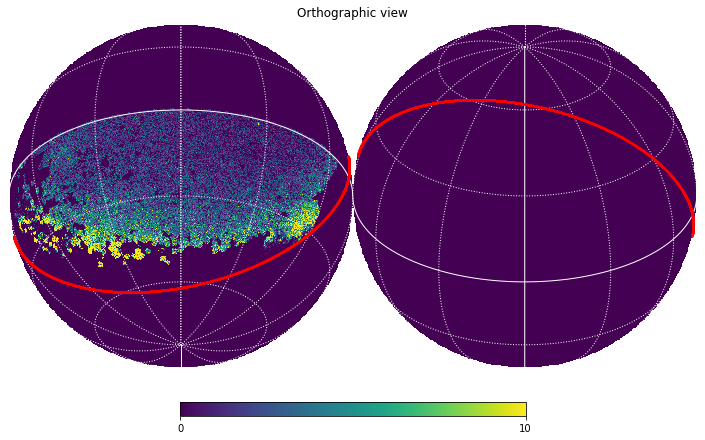

In [21]:
plt.figure(figsize=(10,10))
hp.orthview(map_ps,rot=(180,-30),min=0,max=10,half_sky=False,fig=1,coord='C',notext=True,nest=True)
hp.graticule(c='w')
foo = hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)

The map might look smoother if we downgrade the resolution a bit.

In [22]:
map_ps256 = hp.ud_grade(map_ps,256,order_in='NESTED',order_out='NESTED')

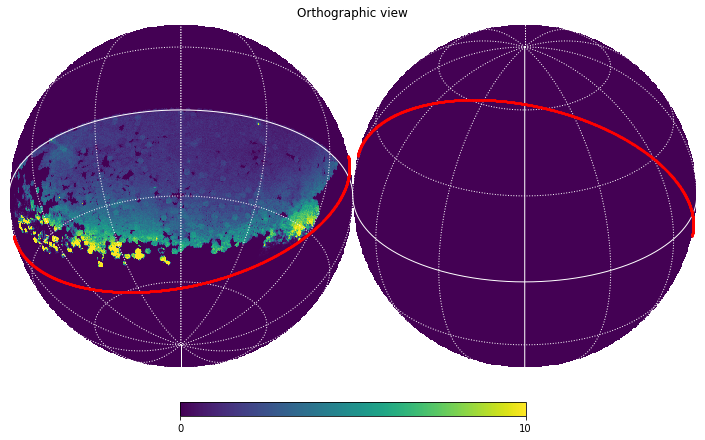

In [23]:
plt.figure(figsize=(10,10))
hp.orthview(map_ps256,rot=(180,-30),min=0,max=10,half_sky=False,fig=1,coord='C',notext=True,nest=True)
hp.graticule(c='w')
foo = hp.projplot(lon,lat,'ro',coord='G',lonlat=True,markersize=1)

### More info
Have a look at the HowTos and Science Examples folders in the notebooks directory for other things you might want to learn how to do.